# Refactor bus corridors

In [1]:
import datetime as dt
import geopandas as gpd
import numpy as np
import pandas as pd

from siuba import *

import B1_bus_corridors as bus_corridors
from A1_rail_ferry_brt import analysis_date
from utilities import GCS_FILE_PATH
from shared_utils import rt_utils

import dask.dataframe as dd
import dask_geopandas


itp_id = 182
date_str = analysis_date.strftime(rt_utils.FULL_DATE_FMT)

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:

FILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"
        
routelines = dask_geopandas.read_parquet(f"{FILE_PATH}routelines_{itp_id}_{date_str}.parquet")
trips = dd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")
stop_times = dd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")
stops = dask_geopandas.read_parquet(f"{FILE_PATH}stops_{itp_id}_{date_str}.parquet")
'''
gdf = bus_corridors.single_operator_hqta(routelines, trips, stop_times, stops)
gdf.to_parquet("./data/182_bus2.parquet")
'''

'\ngdf = bus_corridors.single_operator_hqta(routelines, trips, stop_times, stops)\ngdf.to_parquet("./data/182_bus2.parquet")\n'

In [3]:
import dask_utils 

In [4]:
route_shapes = dask_utils.select_needed_shapes_for_route_network(routelines, trips)
    
all_routes = gpd.GeoDataFrame()
for i in route_shapes.index:
    one_route = route_shapes[route_shapes.index==i]
    gdf = dask_utils.segment_route(one_route)

    all_routes = pd.concat([all_routes, gdf])

# Add HQTA segment ID
all_routes2 = dask_utils.add_segment_id(all_routes)

##generous buffer for street/sidewalk width? 
# Required to spatially find stops within each segment
all_routes3 = dask_utils.add_buffer(all_routes2, buffer_size=50)

In [5]:
# Convert to dask gdf
hqta_segments = dask_geopandas.from_geopandas(all_routes3, npartitions=1)
# Join hqta segment to stops
segment_to_stop = bus_corridors.hqta_segment_to_stop(hqta_segments, stops)

In [6]:
# Within hqta segment, if there are multiple stops, keep stop with highest trip count
segment_to_stop_unique = bus_corridors.hqta_segment_keep_one_stop(segment_to_stop, stop_times)
    
# Get aggregated stops by departure_hour and stop_id
trips_by_stop_hour = dask_utils.stop_times_aggregation_by_hour(stop_times)
    
# By hqta segment, find the max trips for AM/PM peak
segment_with_max_stops = bus_corridors.add_hqta_segment_peak_trips(
    segment_to_stop_unique, trips_by_stop_hour)
    
# Tag whether that row is a HQ transit corr
hq_transit_segments = bus_corridors.identify_hq_transit_corr(segment_with_max_stops)

In [23]:
keep_cols = ["stop_id", "am_max_trips", "pm_max_trips"]
eric2 = eric[keep_cols].drop_duplicates()
tiff2 = hq_transit_segments[keep_cols].drop_duplicates()

In [25]:
m1 = pd.merge(eric2, tiff2,
         on = "stop_id",
         how = "outer",
         validate = "1:1",
         indicator=True
)

m1._merge.value_counts()

left_only     1324
both           909
right_only     822
Name: _merge, dtype: int64

In [27]:
# For the ones that are in both, generated the same number of trips
m1[m1._merge=="both"][m1.am_max_trips_x != m1.am_max_trips_y]

/tmp/ipykernel_1503/4192090017.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,stop_id,am_max_trips_x,pm_max_trips_x,am_max_trips_y,pm_max_trips_y,_merge


In [28]:
m1[m1._merge=="both"][m1.pm_max_trips_x != m1.pm_max_trips_y]

/tmp/ipykernel_1503/3709018195.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,stop_id,am_max_trips_x,pm_max_trips_x,am_max_trips_y,pm_max_trips_y,_merge


In [35]:
eric_stops = m1[m1._merge=="left_only"].stop_id.unique().tolist()

In [36]:
tiff_stops = m1[m1._merge=="right_only"].stop_id.unique().tolist()

<AxesSubplot:>

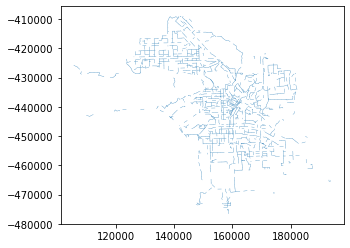

In [42]:
eric[eric.stop_id.isin(eric_stops)].plot()

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.


<AxesSubplot:>

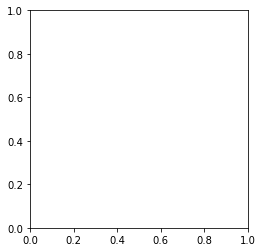

In [43]:
hq_transit_segments[hq_transit_segments.stop_id.isin(eric_stops)].plot()

In [10]:
# calitp-analytics-data/data-analyses/high_quality_transit_areas/bus_corridors/182_bus.parquet
eric = gpd.read_parquet(f"{GCS_FILE_PATH}bus_corridors/182_bus.parquet")

In [ ]:
tiff = gpd.read_parquet(f"./data/182_bus2.parquet")

In [11]:
def stats(df):
    print(df.columns)
    print(df.dtypes)
    print(f"# obs: {len(df)}")
    print(f"# unique stops: {df.stop_id.nunique()}")
    print(f"sum am_max stops: {df.am_max_trips.sum()}")
    print(f"sum pm_max stops: {df.am_max_trips.sum()}")
    print(f"# unique hqta_segment_id: {df.hqta_segment_id.nunique()}")

    
def compare(eric, tiff):
    print("***********Eric************")
    stats(eric)
    print("***********Tiff************")
    stats(tiff)

In [12]:
compare(eric, hq_transit_segments)

***********Eric************
Index(['calitp_itp_id', 'calitp_url_number', 'shape_id', 'geometry',
       'segment_sequence', 'hqta_segment_id', 'stop_id', 'am_max_trips',
       'pm_max_trips', 'hq_transit_corr', 'departure_hour', 'n'],
      dtype='object')
calitp_itp_id           int64
calitp_url_number       int64
shape_id               object
geometry             geometry
segment_sequence       object
hqta_segment_id         int64
stop_id                object
am_max_trips          float64
pm_max_trips          float64
hq_transit_corr          bool
departure_hour        float64
n                     float64
dtype: object
# obs: 2503
# unique stops: 2233
sum am_max stops: 15682.0
sum pm_max stops: 15682.0
# unique hqta_segment_id: 2503
***********Tiff************
Index(['calitp_itp_id', 'stop_id', 'hqta_segment_id', 'segment_sequence',
       'calitp_url_number', 'shape_id', 'geometry', 'am_max_trips',
       'pm_max_trips', 'hq_transit_corr'],
      dtype='object')
calitp_itp_id    

In [ ]:
explore_shapes = [
    "700292_FEB22",
    #"400916_FEB22",
]

explore_stops = [
    #"6535",
    #"5383"
]

explore_stops = tiff[tiff.shape_id.str.startswith("720")].stop_id.unique().tolist()

In [ ]:
tiff[tiff.shape_id.str.startswith("720")].plot()

In [ ]:
eric[eric.shape_id.str.startswith("720")].plot()

In [ ]:
tiff[tiff.stop_id.isin(explore_stops)].plot()

In [ ]:
eric[eric.stop_id.isin(explore_stops)].plot()

In [ ]:
eric[eric.stop_id.isin(explore_stops)].plot(column="segment_sequence")

In [ ]:
tiff[tiff.stop_id.isin(explore_stops)]

In [ ]:
tiff[tiff.stop_id=="6535"]

In [ ]:
tiff[tiff.stop_id.isin(explore_stops)].plot(column="segment_sequence")

In [ ]:
m1 = pd.merge(
    eric,
    tiff,
    on = ["calitp_itp_id", "calitp_url_number", "shape_id", 
          "hqta_segment_id", "segment_sequence", "stop_id"],
    how = "outer",
    #validate="m:m",
    indicator=True
)

In [ ]:
m1._merge.value_counts()

### Find trips that are just AM / PM peak

In [ ]:
# Remove trips that only run during AM/PM peak, because those don't qualify as HQTA
def invalid_trips_only_peak_hours(df):
    trip_cols = ["calitp_itp_id", "trip_id"]
    
    df = df.assign(
        is_am_peak = df.time_of_day.map(lambda x: 1 if x=="AM Peak" 
                                          else 0),
        is_pm_peak = df.time_of_day.map(lambda x: 1 if x=="PM Peak"
                                          else 0),
        is_other = df.time_of_day.map(lambda x: 1 if ((x != "AM Peak") and 
                                                        (x != "PM Peak"))
                                        else 0),
    )
    
    df2 = (df.groupby(trip_cols)
           .agg({"is_am_peak": np.max, 
                 "is_pm_peak": np.max,
                 "is_other": np.max,})
           .reset_index()
          )
    
    # Drop trips that only run AM/PM
    only_peak = df2[(df2.is_am_peak==1) & 
              (df2.is_pm_peak==1) & 
              (df2.is_other==0)].trip_id.compute()
        
    # Return list of trip_ids that are invalid
    return list(only_peak.unique())

In [ ]:
invalid_trips = invalid_trips_only_peak_hours(trip_stops_by_hour)